# 01 - 从零实现线性回归

**Table of contents**<a id='toc0_'></a>    
- [01 生成训练样本](#toc1_1_)    
  - [02 读取数据集](#toc1_2_)    
  - [03 初始化模型参数](#toc1_3_)    
  - [04 定义模型](#toc1_4_)    
  - [05 定义损失函数](#toc1_5_)    
  - [06 定义优化算法](#toc1_6_)    
  - [07 训练](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
import matplotlib.pyplot as plt

## <a id='toc1_1_'></a>[01 生成训练样本](#toc0_)

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features: ', features.shape) # x
print('labels: ', labels.shape) # y

features:  torch.Size([1000, 2])
labels:  torch.Size([1000, 1])


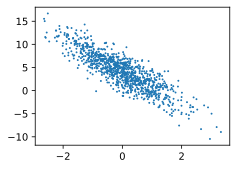

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## <a id='toc1_2_'></a>[02 读取数据集](#toc0_)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) # 使用random.shuffle打乱index
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) # 使用min防止数组最后的batch溢出
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.0541,  0.2039],
        [-1.4477, -1.1215],
        [-1.0363, -1.6811],
        [-0.5362, -1.0420],
        [ 0.6552,  0.6998],
        [ 0.1048,  0.0426],
        [-1.9395, -1.1783],
        [-0.0099,  0.4713],
        [ 1.2564, -0.0068],
        [ 0.5457,  1.5365]]) 
 tensor([[1.4030],
        [5.1052],
        [7.8228],
        [6.6702],
        [3.1328],
        [4.2655],
        [4.3202],
        [2.5834],
        [6.7317],
        [0.0745]])


## <a id='toc1_3_'></a>[03 初始化模型参数](#toc0_)

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # 随机选取w，均值为0，方差为0.01，shape为(2, 1)
b = torch.zeros(1, requires_grad=True) # 选取b为0

In [9]:
print(w, '\n', b)

tensor([[0.0098],
        [0.0055]], requires_grad=True) 
 tensor([0.], requires_grad=True)


## <a id='toc1_4_'></a>[04 定义模型](#toc0_)

In [10]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## <a id='toc1_5_'></a>[05 定义损失函数](#toc0_)

In [11]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## <a id='toc1_6_'></a>[06 定义优化算法](#toc0_)

$$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$$

In [12]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 梯度清零

## <a id='toc1_7_'></a>[07 训练](#toc0_)

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.040960
epoch 2, loss 0.000155
epoch 3, loss 0.000052


In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)
